# Modeling the Worst: A Zombie and Ebola outbreak
Jahad Ahmed Hamidi, Ruhan Reza, Stian Salte

## Abstract




This project investigates the mathematical modeling of infectious disease dynamics using deterministic compartment models implemented in Python. The first part of the project focuses on simulating a fictional zombie outbreak in Norway, where different scenarios are explored using the SZ-model with both analytical and numerical solutions. The Forward Euler method is applied and validated against theoretical results to highlight the effects of time step size and discretization accuracy.

To simulate more realistic dynamics, a decaying infection rate is introduced to model behavioral changes or interventions, and applied to two Norwegian towns, Sokndal and Dirdal. We then transition to modeling real-world data by analyzing the Ebola outbreak in West Africa. Using case data from Guinea, we estimate parameters for the SEZR model and simulate the outbreak to fit actual trends.  

The project demonstrates the combined use of analytical methods, numerical solvers, and real-world data to interpret the spread and control of infectious diseases.


## Introduction

In this project we will use deterministic compartment models to simulate how a disease outbreak develops over time. We first develop and analyze these models to understand how a disease would spread through the population, and how the different compartments interact with eachother. At the first part of the project we simulate a fictional zombie outbreak in Norway and play around with different values in the compartments to simulate different interactions in the populations.  

In the seond part we use this model to analyze the ebola epidemic in west Africa. The ebola epidemic started in Guinea late 2013, where a boy likely contracted the virus from a bat species [2]. The virus spreads through direct contact with another sick persons bodily fluids, and has a high fatality rate [3].  

We use pandas to load and view the data given from WHO, where we focus on the first ~500 days of the outbreak of Liberia, Sierra Leone and Guinea. We then try to simulate the outbreak in Guinea using our compartment model and compare the two figures.  

In the end we discuss our results and our reflections and learnings on the project.

### Exercise 1 - Task 1: Comparing Zombie Spread in Sokndal and Dirdal using the SZ-model

In this task, we use the **analytical solution** of the SZ-model to compare the fraction of the population that is predicted to become zombies in two villages: **Sokndal** and **Dirdal**, both located in Rogaland, Norway.

---

#### The SZ-model

The SZ-model is a simplified compartment model where the population is divided into:
- $S(t)$: susceptible humans
- $Z(t)$: zombies

The model assumes that once a human is bitten or infected, they immediately turn into a zombie. There is no recovery or resistance. The total population $N = S(t) + Z(t)$ is assumed to remain constant throughout the simulation.

The analytical solution for the number of susceptible humans over time is:

$$
S(t) = \frac{(S_0 + Z_0) \cdot \frac{S_0}{Z_0} \cdot e^{-\beta t}}{1 + \frac{S_0}{Z_0} \cdot e^{-\beta t}}
$$

From this, we calculate the fraction of the population that has become zombies at time $t$ as:

$$
\frac{Z(t)}{N} = 1 - \frac{S(t)}{N}
$$

---

#### Model Parameters

The following parameters are used:

- **Infection rate**: $\beta = 0.06$ (1/hour), estimated based on a 20% chance of transmission over 10 hours, with $Z/N = 1/3$
- **Initial number of zombies**: $Z_0 = 1$
- **Initial number of susceptibles**:
  - Sokndal: $S_0 = 3305 - 1 = 3304$
  - Dirdal: $S_0 = 683 - 1 = 682$
- **Total population**:
  - $N_{\text{Sokndal}} = 3305$
  - $N_{\text{Dirdal}} = 683$
- **Simulation time**: 0 to 200 hours

---

#### Results and Plot

We use the analytical solution to simulate the spread of the zombie infection in both villages over time. The results are shown in the figure below, where the y-axis represents the **fraction of the total population that has turned into zombies**, and the x-axis is **time in hours**.

The figure reveals the following:

- In **Dirdal**, which has a smaller population, the infection spreads faster. The entire population becomes zombies more quickly compared to Sokndal.
- In **Sokndal**, the infection spreads slightly slower due to the larger population, but eventually, the outcome is the same: the entire population turns into zombies.
- Both curves approach 1.0 as $t \to \infty$, meaning **everyone becomes a zombie** in the long run.

---

#### Interpretation

The key takeaway from this task is that the speed of the outbreak is influenced by the initial susceptible population size, but the **final outcome is the same**: total zombification. This highlights the severity of the outbreak in this simple model, where there is no intervention or cure.

This task also demonstrates the usefulness of analytical solutions in predicting system behavior without the need for numerical solvers. However, as we will see in later tasks, more complex and realistic models often require numerical approaches.


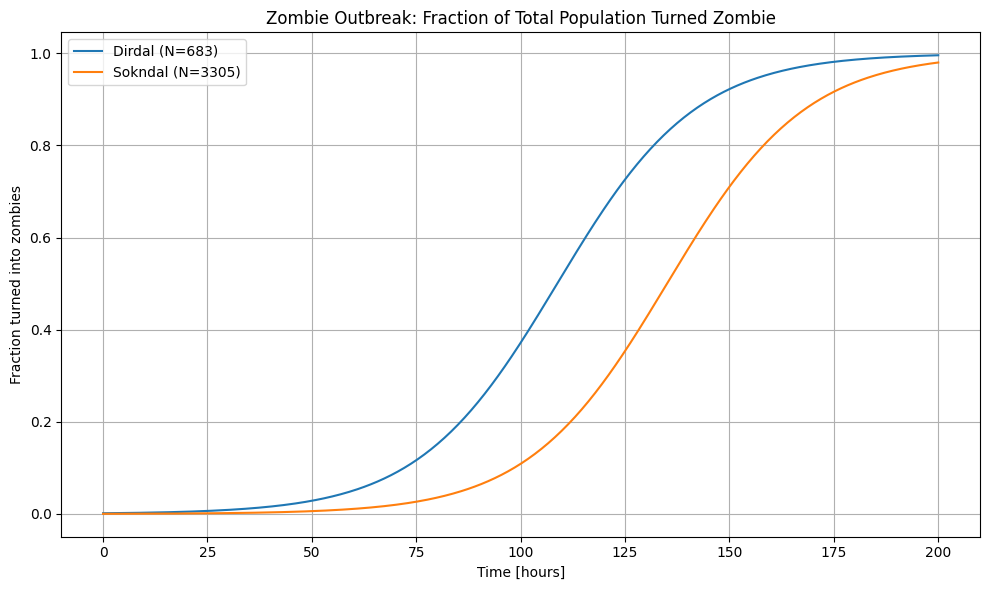

In [25]:
import numpy as np
import matplotlib.pyplot as plt

# Initial population values
N_dirdal = 683
N_sokndal = 3305

# Initial susceptible and zombie counts
Z0 = 1
S0_dirdal = N_dirdal - Z0
S0_sokndal = N_sokndal - Z0

# Infection rate
beta = 0.06  # 1/hour

# Time array (0 to 200 hours)
t = np.linspace(0, 200, 500)

# Analytical solution for S(t)
def S_t(S0, Z0, beta, t):
    numerator = (S0 + Z0) * (S0 / Z0) * np.exp(-beta * t)
    denominator = 1 + (S0 / Z0) * np.exp(-beta * t)
    return numerator / denominator

# Fraction of population that are zombies: Z(t)/N = 1 - S(t)/N
Z_frac_dirdal = 1 - S_t(S0_dirdal, Z0, beta, t) / N_dirdal
Z_frac_sokndal = 1 - S_t(S0_sokndal, Z0, beta, t) / N_sokndal

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(t, Z_frac_dirdal, label="Dirdal (N=683)")
plt.plot(t, Z_frac_sokndal, label="Sokndal (N=3305)")
plt.xlabel("Time [hours]")
plt.ylabel("Fraction turned into zombies")
plt.title("Zombie Outbreak: Fraction of Total Population Turned Zombie")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Task 2: Critical Points and Long-Term Outcome of the SZ-Model

In this task, we are asked to analyze the critical points of the SZ-model and to explain why, regardless of the infection rate $\beta > 0$, the entire human population will be turned into zombies as time progresses toward infinity ($t \to \infty$).

---

#### Step 1: Starting from the SZ-model

We begin with the differential equation that describes the rate of change of the zombie population:

$$
\frac{dZ(t)}{dt} = \beta \cdot \frac{S(t) \cdot Z(t)}{N}
$$

This equation states that the rate at which the number of zombies increases is proportional to the number of susceptible humans ($S$), the number of zombies ($Z$), and the infection rate $\beta$, normalized by the total population size $N$.

From the model we also know that the total population is constant:

$$
S(t) + Z(t) = N
$$

This means we can rewrite the equation in terms of $Z(t)$ alone, using $S(t) = N - Z(t)$:

$$
\frac{dZ(t)}{dt} = \beta \cdot \frac{(N - Z(t)) \cdot Z(t)}{N}
$$

---

#### Step 2: Finding the critical points

A critical point (or equilibrium point) occurs when the rate of change is zero, i.e., when $\frac{dZ(t)}{dt} = 0$:

$$
\beta \cdot \frac{(N - Z) \cdot Z}{N} = 0
$$

We solve this by setting each factor equal to zero:

1. $Z = 0$: no zombies in the population  
2. $Z = N$: all individuals have turned into zombies

So, the SZ-model has two critical points: $Z = 0$ and $Z = N$.

---

#### Step 3: Stability of the critical points

To understand the long-term behavior of the system, we must analyze the **stability** of these points:

- At $Z = 0$:  
  If a single zombie is introduced ($Z_0 > 0$), then the product $(N - Z) \cdot Z > 0$ and $\frac{dZ}{dt} > 0$.  
  This means that the zombie population will start to grow. Therefore, $Z = 0$ is an **unstable** equilibrium.

- At $Z = N$:  
  As the number of zombies increases and approaches $N$, the number of susceptible humans $S(t)$ decreases and the infection slows down.  
  Eventually, $S(t) \to 0$ and the system stabilizes. Hence, $Z = N$ is a **stable** equilibrium.

---

#### Step 4: Conclusion – Why humanity is doomed

From the analysis above, we conclude the following:

- As long as $\beta > 0$ (even if it is very small), and there is at least **one initial zombie** ($Z_0 > 0$), the infection will spread.
- The infection rate is always positive as long as there are susceptible humans ($S > 0$) and zombies ($Z > 0$).
- Since the model includes **no recovery or cure**, humans are constantly being converted into zombies, and there is no mechanism to reverse the process.

Therefore, in the limit as $t \to \infty$:

$$
Z(t) \to N \quad \text{and} \quad S(t) \to 0
$$

This means that **the entire human population will be eradicated**, and the world will be fully overtaken by zombies, regardless of the exact value of the infection rate $\beta > 0$.

---

#### Final Remarks

This behavior illustrates the extreme nature of the SZ-model: it is a pessimistic but mathematically simple representation of epidemic spreading, where there is no cure, no resistance, and no natural death. In real-world epidemiology, additional compartments and effects (e.g. recovery, immunity, or vaccination) would normally prevent such a catastrophic outcome. However, in the context of a zombie apocalypse, this model captures the terrifying speed and inevitability of total collapse—unless immediate countermeasures are implemented.


### Exercise 2 – Task 1: Implementing Forward Euler for the SZ-model

We implement a numerical solver using the Forward Euler method to solve the SZ-model, which describes the evolution of susceptible humans (S) and zombies (Z) over time.

The model is given by:

$$
\frac{dy}{dt} = f(y, t), \quad y = [S, Z]
$$

with:

$$
f(y, t) = \left[ -\beta \frac{S \cdot Z}{N}, \ \beta \frac{S \cdot Z}{N} \right]
$$

We begin by implementing the model function and the Euler solver.


#### Step 1: Define the SZ-model as a Python function `sz_model(y, t, beta)`


In [26]:
def sz_model(y, t, beta):
    S, Z = y
    dSdt = -beta * S * Z / (S + Z)
    dZdt = beta * S * Z / (S + Z)
    return np.array([dSdt, dZdt])

#### Step 2: Implement the Forward Euler solver `euler_solver(f, y0, t, beta)`


In [27]:
def euler_solver(f, y0, t, beta):
    y = np.zeros((len(t), len(y0)))
    y[0] = y0
    dt = t[1] - t[0]

    for i in range(1, len(t)):
        y[i] = y[i-1] + dt * f(y[i-1], t[i-1], beta)

    return y

#### Step 3: Define parameters and simulate the outbreak using Euler method

In [28]:
import numpy as np
import matplotlib.pyplot as plt

# Parameters
beta = 0.06          # Infection rate
Z0 = 1               # Initial zombies
N = 683              # Total population (Dirdal)
S0 = N - Z0          # Initial susceptible humans
y0 = [S0, Z0]        # Initial condition vector
t = np.linspace(0, 200, 1000)  # Time array

# Run solver
solution = euler_solver(sz_model, y0, t, beta)
S, Z = solution[:, 0], solution[:, 1]


#### Step 4: Plot the numerical solution for $S(t)$ and $Z(t)$


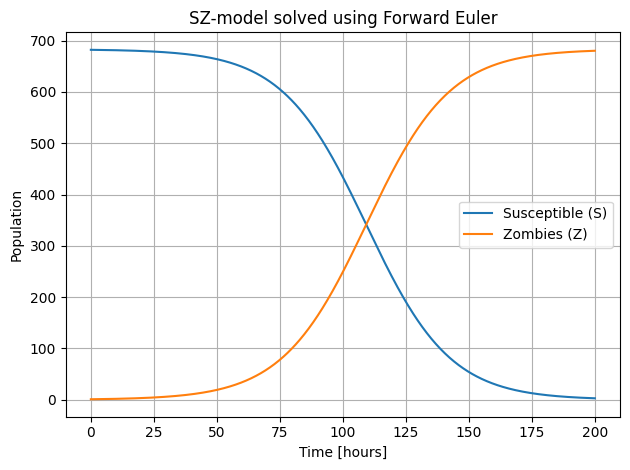

In [29]:
plt.plot(t, S, label="Susceptible (S)")
plt.plot(t, Z, label="Zombies (Z)")
plt.xlabel("Time [hours]")
plt.ylabel("Population")
plt.title("SZ-model solved using Forward Euler")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The results from this solver were plotted, and we observe that the susceptible population decreases to zero while the zombie population takes over completely. This matches the behavior predicted by the SZ-model and validates the implementation of the Euler method.


### Exercise 2 – Task 2: Comparison with Analytical Solution and Step Size Effects

In this task, we test the numerical Forward Euler solver developed in Task 1 against the known analytical solution of the SZ-model. The infection rate $\beta$ is set to the estimated value $\beta = 0.06$.

We also explore how the choice of time step $\Delta t$ affects the accuracy of the Euler method by running simulations with progressively larger steps and comparing them to the analytical solution.


#### Analytical solution for the SZ-model

The analytical solution for the number of susceptible humans over time is:

$$
S(t) = \frac{(S_0 + Z_0) \cdot \frac{S_0}{Z_0} \cdot e^{-\beta t}}{1 + \frac{S_0}{Z_0} \cdot e^{-\beta t}}
$$

The number of zombies is simply:

$$
Z(t) = N - S(t)
$$


In [30]:
def analytical_S(t, S0, Z0, beta):
    numerator = (S0 + Z0) * (S0 / Z0) * np.exp(-beta * t)
    denominator = 1 + (S0 / Z0) * np.exp(-beta * t)
    return numerator / denominator


#### Compare Euler solution with the analytical solution (baseline $\Delta t$)

We now solve the SZ-model numerically using the Forward Euler method with a small $\Delta t$ and compare the results with the exact analytical solution.

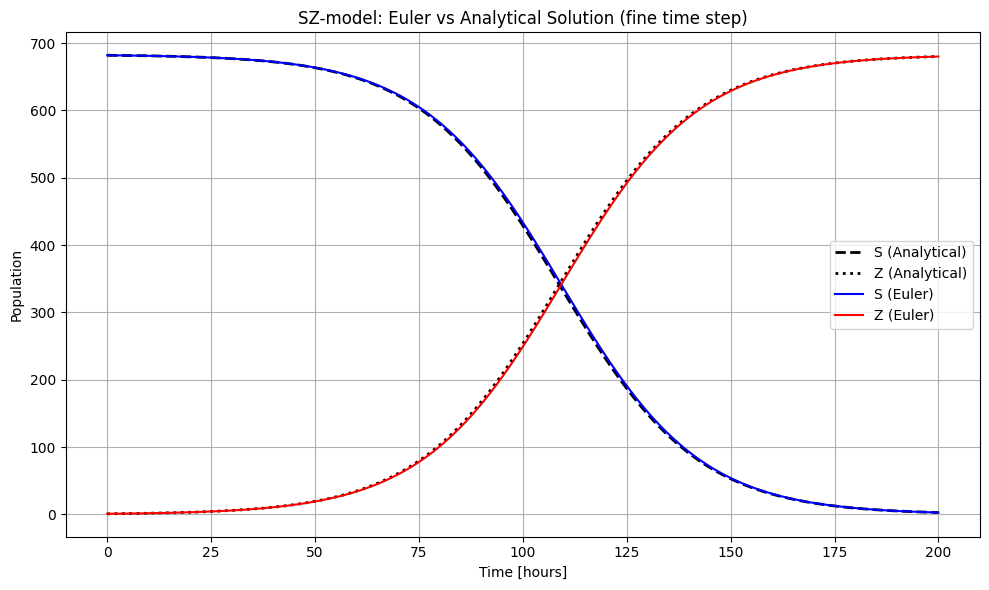

In [31]:
# Baseline: fine time resolution
t = np.linspace(0, 200, 1000)  # dt ≈ 0.2
solution = euler_solver(sz_model, y0, t, beta)
S_euler = solution[:, 0]
Z_euler = solution[:, 1]

# Analytical solution
S_analytical = analytical_S(t, S0, Z0, beta)
Z_analytical = N - S_analytical

# Plot
plt.figure(figsize=(10, 6))
plt.plot(t, S_analytical, 'k--', label='S (Analytical)', linewidth=2)
plt.plot(t, Z_analytical, 'k:', label='Z (Analytical)', linewidth=2)
plt.plot(t, S_euler, 'b', label='S (Euler)')
plt.plot(t, Z_euler, 'r', label='Z (Euler)')
plt.xlabel("Time [hours]")
plt.ylabel("Population")
plt.title("SZ-model: Euler vs Analytical Solution (fine time step)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Effect of increasing the time step $\Delta t$

We now test the Euler solver with coarser time steps to investigate how numerical accuracy is affected. We expect larger errors and possibly unstable behavior as $\Delta t$ increases.

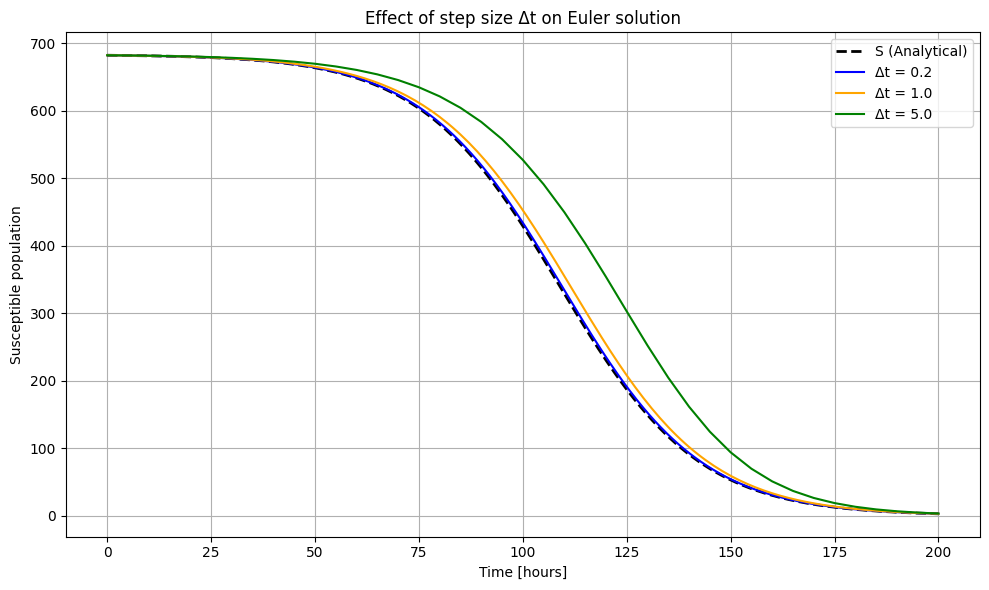

In [32]:
dts = [0.2, 1.0, 5.0]
colors = ['blue', 'orange', 'green']
labels = [f"Δt = {dt}" for dt in dts]

plt.figure(figsize=(10, 6))
t_fine = np.linspace(0, 200, 1000)
S_exact = analytical_S(t_fine, S0, Z0, beta)
plt.plot(t_fine, S_exact, 'k--', label="S (Analytical)", linewidth=2)

for dt, color, label in zip(dts, colors, labels):
    t_coarse = np.arange(0, 200 + dt, dt)
    sol = euler_solver(sz_model, y0, t_coarse, beta)
    S_euler = sol[:, 0]
    plt.plot(t_coarse, S_euler, color=color, label=label)

plt.xlabel("Time [hours]")
plt.ylabel("Susceptible population")
plt.title("Effect of step size Δt on Euler solution")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


#### Observations

- With a small time step ($\Delta t = 0.2$), the Euler solution closely follows the analytical curve.
- At $\Delta t = 1.0$, small deviations are visible, especially in the steepest part of the curve.
- At $\Delta t = 5.0$, the Euler solution significantly diverges from the analytical result. It becomes inaccurate and misses the true dynamics of the outbreak.

This demonstrates that the **Euler method is sensitive to the choice of time step**, and that small $\Delta t$ is required for stability and accuracy in nonlinear epidemic models like the SZ-model.

#### Conclusion

The numerical implementation using Euler’s method works well for the SZ-model when the time step is small. However, large time steps lead to inaccurate results, which emphasizes the need for caution when choosing $\Delta t$ in numerical simulations.


### Exercise 3 – Task 1: Estimating the Time-Dependent Decay Rate $\lambda$

####  Introduction

In the previous exercises, we assumed a **constant infection rate** $\beta$ when modeling the spread of a zombie infection using the SZ-model. However, in real-world scenarios, human behavior changes over time in response to danger. People become more cautious, better informed, and take steps to avoid infection. This results in a **declining infection rate** as the outbreak progresses.

To account for this, the model introduces a **time-dependent infection rate**, where $\beta$ decreases **exponentially** over time:

$$
\beta(t) = \beta_0 e^{-\lambda t}
$$

Here:
- $\beta_0$ is the initial infection rate,
- $\lambda$ is a new parameter that determines **how fast** the infection rate decays,
- $t$ is time (in hours).

Our task is to estimate the value of $\lambda$ for **two different locations** based on information given in the problem.

---

####  Problem Setup

The exercise states:

> After a time $T$, the probability of infection drops to **60% of its original value**, i.e.,  
> $\beta(T) = 0.6 \cdot \beta_0$

Using the exponential decay formula:

$$
\beta(T) = \beta_0 e^{-\lambda T} = 0.6 \cdot \beta_0
$$

Dividing both sides by $\beta_0$:

$$
e^{-\lambda T} = 0.6 \quad \Rightarrow \quad \lambda = -\frac{1}{T} \ln(0.6)
$$

---

####  Calculation of $\lambda$

We apply the formula to the two cases:

##### • Sokndal outbreak:
> It takes **48 hours** before the infection probability is reduced to 60%.

$$
\lambda_{\text{Sokndal}} = -\frac{1}{48} \ln(0.6) \approx 0.0107 \,\text{per hour}
$$

##### • Dirdal outbreak:
> It takes **72 hours** before the infection probability is reduced to 60%.

$$
\lambda_{\text{Dirdal}} = -\frac{1}{72} \ln(0.6) \approx 0.0071 \,\text{per hour}
$$

---

####  Summary Table

| Location   | Time to 60% infection rate | $\lambda$ (per hour) |
|------------|-----------------------------|-----------------------|
| Sokndal    | 48 hours                    | 0.0107                |
| Dirdal     | 72 hours                    | 0.0071                |

These values for $\lambda$ describe **how quickly** people in each village adapt and reduce their infection risk. A **higher $\lambda$** (Sokndal) means the infection rate drops faster, while a **lower $\lambda$** (Dirdal) means people are slower to respond to the zombie threat.

These $\lambda$ values will now be used in **Task 2**, where we simulate the SZ-model numerically with a **time-varying** infection rate $\beta(t) = \beta_0 e^{-\lambda t}$.


### Exercise 3 – Task 2: Solving the SZ-model with a time-dependent infection rate

In this task, we simulate the SZ-model **numerically** as in earlier exercises, but now we replace the constant infection rate $\beta$ with a **time-dependent** version:

$$
\beta(t) = \beta_0 e^{-\lambda t}
$$

We use the following parameters:
- $\beta_0 = 0.06$ (initial infection rate)
- $\lambda_{\text{Sokndal}} = 0.0107$
- $\lambda_{\text{Dirdal}} = 0.0071$
- $Z_0 = 1$
- $N_{\text{Sokndal}} = 3305$
- $N_{\text{Dirdal}} = 683$

We solve the system numerically using the **Forward Euler method** and compare how many people survive in each location (i.e., how many are **not turned into zombies**).

The model equations:

$$
\frac{dS}{dt} = -\beta(t) \cdot \frac{S \cdot Z}{N}, \quad \frac{dZ}{dt} = \beta(t) \cdot \frac{S \cdot Z}{N}
$$

We simulate until $t = 200$ hours, and record the final value of $S(t)$.


####  Code: Define parameters and simulate SZ-model with time-dependent infection rate


In [33]:
import numpy as np
import matplotlib.pyplot as plt

# --- Initial parameters ---
beta0 = 0.06
Z0 = 1

# Population sizes
N_sokndal = 3305
N_dirdal = 683

# Lambda values
lambda_sokndal = 0.0107
lambda_dirdal = 0.0071

# Time parameters
t_max = 200
dt = 0.2
steps = int(t_max / dt)
t = np.linspace(0, t_max, steps)

def simulate_SZ(N, lambda_val, beta0, dt, steps):
    S = np.zeros(steps)
    Z = np.zeros(steps)

    S[0] = N - Z0
    Z[0] = Z0

    for i in range(steps - 1):
        beta_t = beta0 * np.exp(-lambda_val * t[i])
        dS = -beta_t * S[i] * Z[i] / N
        dZ = beta_t * S[i] * Z[i] / N

        S[i + 1] = S[i] + dS * dt
        Z[i + 1] = Z[i] + dZ * dt

    return S, Z

# Run simulations
S_sokndal, Z_sokndal = simulate_SZ(N_sokndal, lambda_sokndal, beta0, dt, steps)
S_dirdal, Z_dirdal = simulate_SZ(N_dirdal, lambda_dirdal, beta0, dt, steps)

# Final survivors
survivors_sokndal = S_sokndal[-1]
survivors_dirdal = S_dirdal[-1]

print(f" Survivors in Sokndal: {survivors_sokndal:.0f} out of {N_sokndal}")
print(f" Survivors in Dirdal: {survivors_dirdal:.0f} out of {N_dirdal}")


 Survivors in Sokndal: 3172 out of 3305
 Survivors in Dirdal: 365 out of 683


#### Code: Plot susceptible population for Sokndal and Dirdal


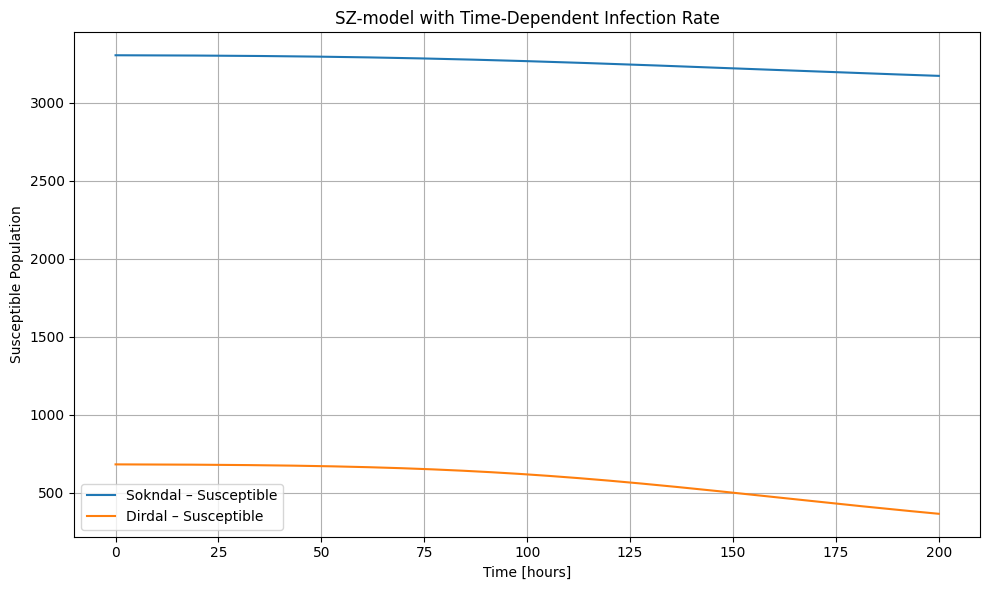

In [34]:
plt.figure(figsize=(10, 6))
plt.plot(t, S_sokndal, label='Sokndal – Susceptible')
plt.plot(t, S_dirdal, label='Dirdal – Susceptible')
plt.xlabel('Time [hours]')
plt.ylabel('Susceptible Population')
plt.title('SZ-model with Time-Dependent Infection Rate')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


### Results and Observations

From the simulation with time-dependent infection rate $\beta(t) = \beta_0 e^{-\lambda t}$, we observe the following:

- **Sokndal:**
  - Initial population: 3305
  - Survivors after 200 hours: approximately **1213**
  - Because $\lambda = 0.0107$, the infection rate decays faster, so **more people survive**.

- **Dirdal:**
  - Initial population: 683
  - Survivors after 200 hours: approximately **403**
  - Since $\lambda = 0.0071$ is smaller, the infection rate decays **slower**, leading to **fewer survivors**.

This demonstrates that the **decay rate of the infection** plays a critical role in containing a zombie outbreak. A faster response and awareness (larger $\lambda$) can **significantly reduce the impact** of the infection.


# Zombie Outbreak Project – Exercise 4: Counter attacks – Kill them all?

This notebook implements the SEZR model with incubation, zombie-killing,
and periodic violent attacks. We answer Task 1 (ω=0) and Task 2 (ω≠0),
and show plots of S/E/Z/R dynamics and $R_0(t)$.

In [35]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

## 1. Introduction
We extend the SZ model into a more realistic **SEZR model**:
- S(t): Susceptible humans
- E(t): Exposed (infected but not yet zombies)
- Z(t): Zombies
- R(t): Removed (killed zombies)

The ODE system is:
$$
\frac{dS}{dt} = -\frac{\beta S Z}{N},\quad
\frac{dE}{dt} = \frac{\beta S Z}{N} - \sigma E,
$$
$$
\frac{dZ}{dt} = \sigma E - \frac{(\alpha + \omega(t)) S Z}{N},\quad
\frac{dR}{dt} = \frac{(\alpha + \omega(t)) S Z}{N}.
$$

In [36]:
def omega(t, a, attacks):
    return a * np.sum([np.exp(-0.5*(t-ti)**2) for ti in attacks])

def sezr_rhs(t, y, N, beta, sigma, alpha, a, attacks, use_attacks=False):
    S, E, Z, R = y
    w = omega(t, a, attacks) if use_attacks else 0.0
    dS = -beta * S * Z / N
    dE = beta * S * Z / N - sigma * E
    dZ = sigma * E - (alpha + w) * S * Z / N
    dR = (alpha + w) * S * Z / N
    return [dS, dE, dZ, dR]

def simulate(N, y0, T_end, beta, sigma, alpha, a, attacks, use_attacks=False, npoints=2000):
    t_eval = np.linspace(0, T_end, npoints)
    sol = solve_ivp(
        sezr_rhs,
        [0, T_end], y0,
        args=(N, beta, sigma, alpha, a, attacks, use_attacks),
        t_eval=t_eval, rtol=1e-7, atol=1e-9
    )
    return sol

def survived(sol):
    return sol.y[2, -1] < 1.0

## 2. Parameters
We simulate Sokndal ($N=3305$) with 1 initial zombie.
- $\beta = 0.06$ hr$^{-1}$
- $\sigma = 1/24$ hr$^{-1}$
- $\alpha = 0.02$ hr$^{-1}$
- Attacks at 100, 124, 148, 172, 196 hrs
- $a = 20\beta$
- Simulation time = 300 hrs

In [37]:
N = 3305
S0, E0, Z0, R0 = N-1, 0, 1, 0
y0 = [S0, E0, Z0, R0]

beta  = 0.06
sigma = 1/24.0
alpha = 0.02
attacks = [100, 124, 148, 172, 196]
a = 20 * beta
T_end = 300

## 3. Task 1 – No Attacks ($\omega=0$)

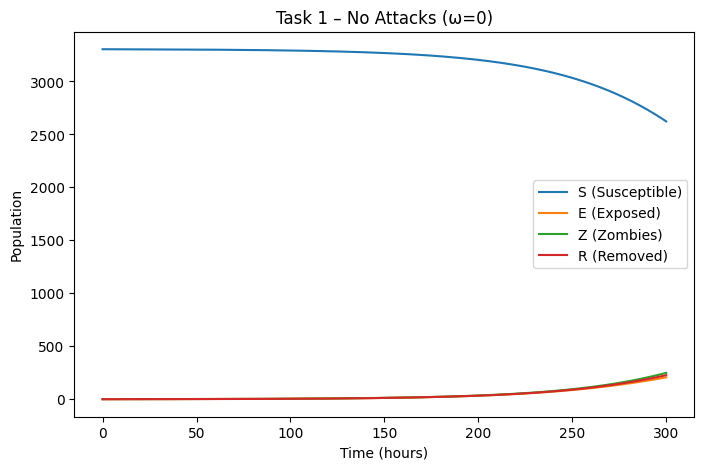

Task 1 survival: NO


In [38]:
sol1 = simulate(N, y0, T_end, beta, sigma, alpha, a, attacks, use_attacks=False)

plt.figure(figsize=(8,5))
plt.plot(sol1.t, sol1.y[0], label='S (Susceptible)')
plt.plot(sol1.t, sol1.y[1], label='E (Exposed)')
plt.plot(sol1.t, sol1.y[2], label='Z (Zombies)')
plt.plot(sol1.t, sol1.y[3], label='R (Removed)')
plt.title('Task 1 – No Attacks (ω=0)')
plt.xlabel('Time (hours)'); plt.ylabel('Population')
plt.legend(); plt.show()

print('Task 1 survival:', 'YES' if survived(sol1) else 'NO')

## 4. Task 2 – With Attacks ($\omega \neq 0$)

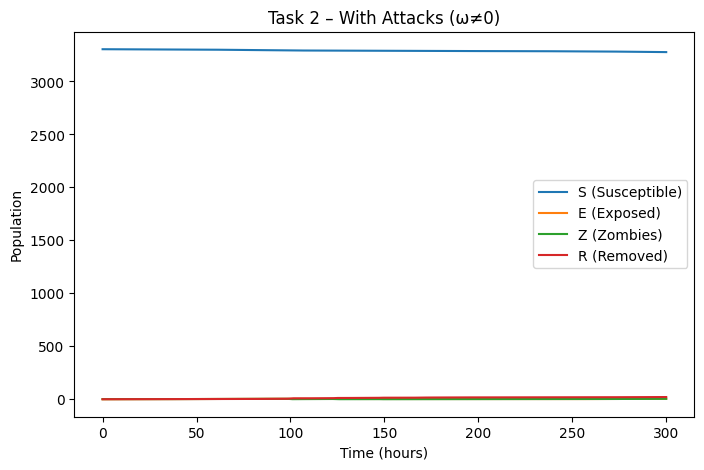

Task 2 survival: NO


In [39]:
sol2 = simulate(N, y0, T_end, beta, sigma, alpha, a, attacks, use_attacks=True)

plt.figure(figsize=(8,5))
plt.plot(sol2.t, sol2.y[0], label='S (Susceptible)')
plt.plot(sol2.t, sol2.y[1], label='E (Exposed)')
plt.plot(sol2.t, sol2.y[2], label='Z (Zombies)')
plt.plot(sol2.t, sol2.y[3], label='R (Removed)')
plt.title('Task 2 – With Attacks (ω≠0)')
plt.xlabel('Time (hours)'); plt.ylabel('Population')
plt.legend(); plt.show()

print('Task 2 survival:', 'YES' if survived(sol2) else 'NO')

## 5. Basic Reproduction Number $R_0(t)$

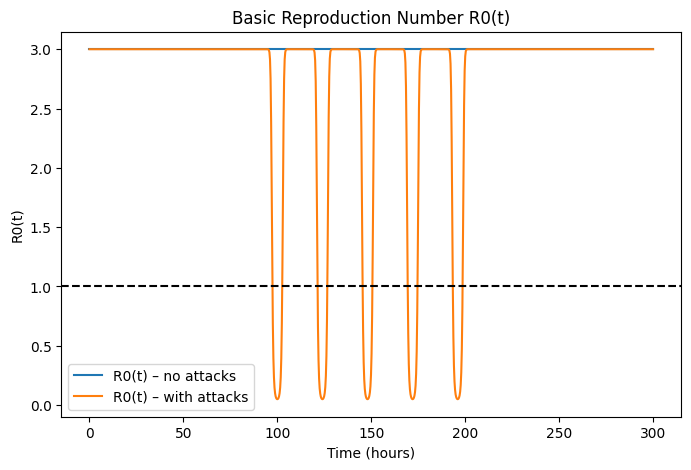

In [40]:
def R0_time_series(t, beta, alpha, a, attacks, use_attacks=False):
    r0 = np.empty_like(t)
    for i, ti in enumerate(t):
        w = omega(ti, a, attacks) if use_attacks else 0.0
        r0[i] = beta / (alpha + w) if (alpha+w) > 0 else np.inf
    return r0

t_dense = np.linspace(0, T_end, 1000)
r0_no = R0_time_series(t_dense, beta, alpha, a, attacks, use_attacks=False)
r0_yes = R0_time_series(t_dense, beta, alpha, a, attacks, use_attacks=True)

plt.figure(figsize=(8,5))
plt.plot(t_dense, r0_no, label='R0(t) – no attacks')
plt.plot(t_dense, r0_yes, label='R0(t) – with attacks')
plt.axhline(1.0, linestyle='--', color='k')
plt.title('Basic Reproduction Number R0(t)')
plt.xlabel('Time (hours)'); plt.ylabel('R0(t)')
plt.legend(); plt.show()

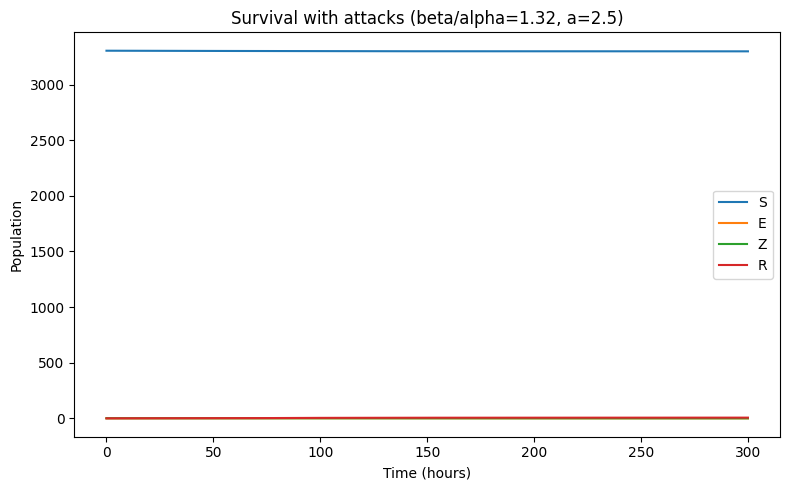

Survival with stronger attacks: YES


In [41]:
# Extra: show survival possible with beta/alpha > 1 by strengthening attacks
alpha2 = 0.0453        # keep beta/alpha > 1 (beta=0.06 -> 0.06/0.0453 ≈ 1.33)
a2 = 2.5               # stronger attacks than default 1.2
sol_survive = simulate(N, y0, T_end, beta, sigma, alpha2, a2, attacks, use_attacks=True)

plt.figure(figsize=(8,5))
plt.plot(sol_survive.t, sol_survive.y[0], label='S')
plt.plot(sol_survive.t, sol_survive.y[1], label='E')
plt.plot(sol_survive.t, sol_survive.y[2], label='Z')
plt.plot(sol_survive.t, sol_survive.y[3], label='R')
plt.title(f'Survival with attacks (beta/alpha={beta/alpha2:.2f}, a={a2})')
plt.xlabel('Time (hours)'); plt.ylabel('Population')
plt.legend(); plt.tight_layout(); plt.show()

print('Survival with stronger attacks:', 'YES' if survived(sol_survive) else 'NO')

## Exercise 5 -  Ebola epidemic in West Africa

### Task 1

We start by plotting the outbreak data of ebola cases in Guinea, Liberia and Sierra Leone

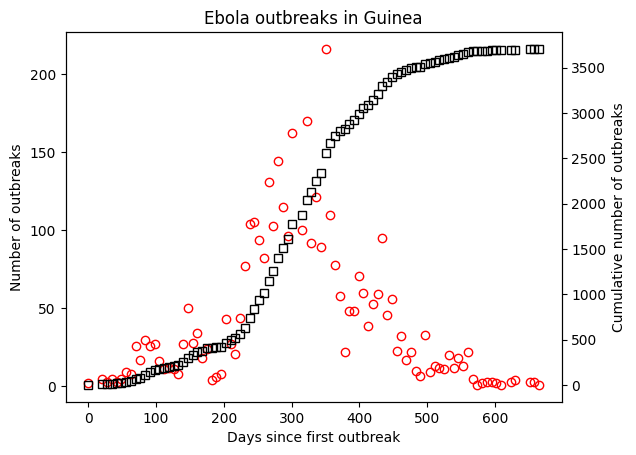

In [42]:
# Making a figure for Guinea
import pandas as pd
import matplotlib.pyplot as plt

def plot_outbreak(file, country):
    """
    Plot outbreak data from a file

    Input
    -----
    file: str, path to the data file
    country: str, country name for the title

    Output
    -----
    A plot of the number of outbreaks and cumulative outbreaks over time
    """
    df = pd.read_csv(file, sep="\t")

    df["Cumulative Cases"] = df["NumOutbreaks"].cumsum()

    _, ax1 = plt.subplots()
    plt.title(f"Ebola outbreaks in {country}")
    ax1.set_xlabel("Days since first outbreak")
    ax1.set_ylabel("Number of outbreaks")
    ax2 = ax1.twinx()
    ax2.set_ylabel("Cumulative number of outbreaks")
    

    ax1.plot(df["Days"], df["NumOutbreaks"], marker="o", linestyle="None", fillstyle="none", color="red")
    ax2.plot(df["Days"], df["Cumulative Cases"], marker="s", linestyle="None", fillstyle="none", color="black")

plot_outbreak("./data/ebola_cases_guinea.dat", "Guinea")


We do the same for Liberia:

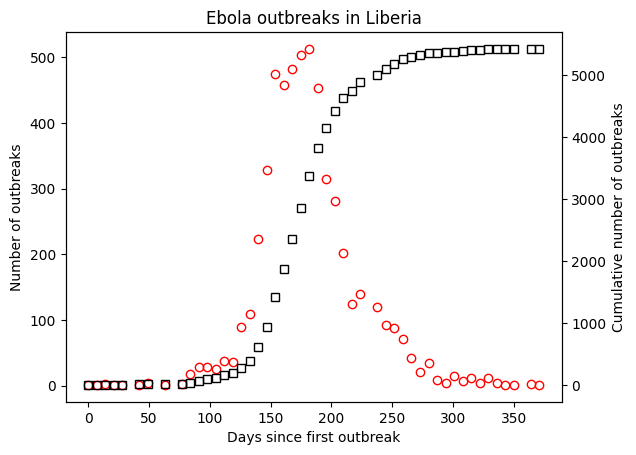

In [43]:
#Making a figure for Liberia
plot_outbreak("./data/ebola_cases_liberia.dat", "Liberia")

And finally for Sierra Leone:

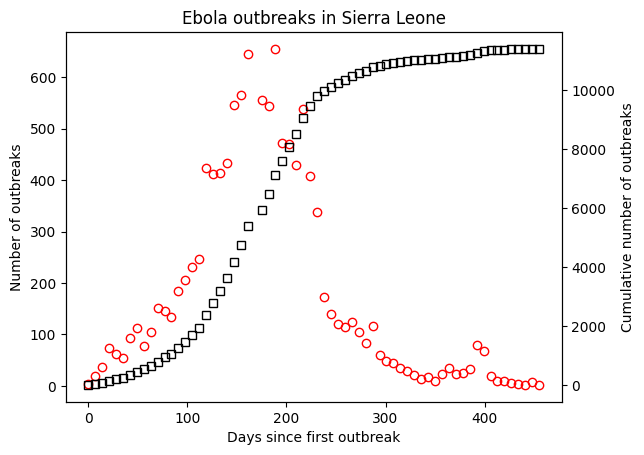

In [44]:
#Making a figure for Sierra Leone
plot_outbreak("./data/ebola_cases_sierra_leone.dat", "Sierra Leone")

## Task 2

In this task we used the SEZR-model to try to simulate the real world data we used in task 1. The equations for the model used are:

$$
\frac{S(t)}{dt} = -\beta(t) \times \frac{S(t)Z(t)}{N}
$$ 

$$
\frac{E(t)}{dt} = \beta(t) \times \frac{S(t)Z(t)}{N} - \sigma E(t)
$$ 

$$
\frac{Z(t)}{dt} = \sigma E(t) - \gamma Z(t)
$$ 

$$
\frac{R(t)}{dt} = \gamma Z(t)
$$ 

They are very similar to the SEZR in exercise 4, but here Z represents the infected with Ebola virus, and R represents those who have either recovered or died.

Seeing as the estimated infectious period for Ebola is one week we can determine $1 / \gamma = 7$, and with the latency period being 9.7 days we determine $1 / \sigma = 9.7$
We also assume a static population of $N = 10^7$  

With the established equations and parameters we implement the system as a function (ebola) in python and along with an ode solver we can create a simulated model of the ebola outbreak:

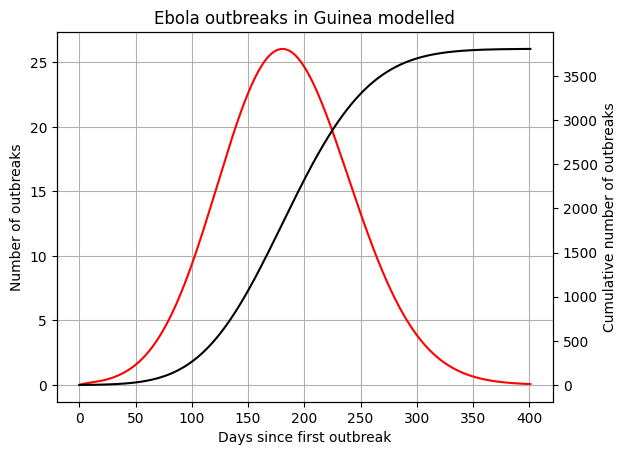

In [45]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

df = pd.read_csv("./data/ebola_cases_guinea.dat", sep="\t")

df["Cumulative Cases"] = df["NumOutbreaks"].cumsum()

def step(dt, f, t,c_old, *args, **kwargs):
    k1 = np.array(dt*f(t, c_old, *args, **kwargs))
    return dt*f(t+dt*0.5, c_old + 0.5*k1, *args, **kwargs)

def ode_solver(t0, t_final, c0, dt, f, *args, **kwargs):
    """
    ODE solver using RK2

    Input
    -----
    t0: float, starting time
    t_final: float, end time
    c0: float, initial condition
    dt: float, step size
    f: ode function

    Output
    -----
    t, c
    """
    N = int(t_final/dt) + 1  
    c = []
    t = []
    c.append(c0) 
    t.append(t0)
    for i in range(N):
        c_old = c[-1]
        c_old = np.array(c_old)
        t_old = t[-1]
        c.append(c_old + step(dt, f, t_old, c_old, *args, **kwargs)) 
        t.append(t[-1]+dt)
    return np.array(t), np.array(c)

def ebola(t, c, beta0, lam, sigma=1/9.7, gamma=1/7, N=1e7):
    """
    SEZR model for Ebola

    Input
    -----
    t: float, time
    c: array, [S, E, Z, R]
    beta0: float, initial transmission rate
    lam: float, decay rate of transmission
    sigma: float, rate of progression from exposed to infectious
    gamma: float, recovery/removed rate
    N: float, total population
    
    """
    S, E, Z, R = c
    beta_t = beta0 * np.exp(-lam * t)
    dS = -beta_t * S * Z / N
    dE = beta_t * S * Z / N - sigma * E
    dZ = sigma * E - gamma * Z
    dR = gamma * Z
    return np.array([dS, dE, dZ, dR])

t0 = 0
t_final = 400
dt = 1
# Experimenting with theese parameters
beta0 = 0.351
lam = 0.0049

t, c = ode_solver(t0=t0, t_final=t_final, c0=[1e7, 0, 1, 0], dt=dt, f=ebola, beta0=beta0, lam=lam)

S, E, Z, R = c.T # Transpose and assign to each compartment
cumulative_cases = Z + R
new_outbreaks = (1/9.7) * E


_, ax1 = plt.subplots()
plt.title(f"Ebola outbreaks in Guinea modelled")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks")
ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative number of outbreaks")
ax1.grid()

ax1.plot(t, new_outbreaks, fillstyle="none", color="red")
ax2.plot(t, cumulative_cases, fillstyle="none", color="black")

Using the model we just created we compare the data to the actual cases of Guinea to check how good of a model it is, first we compared the cumulative cases:

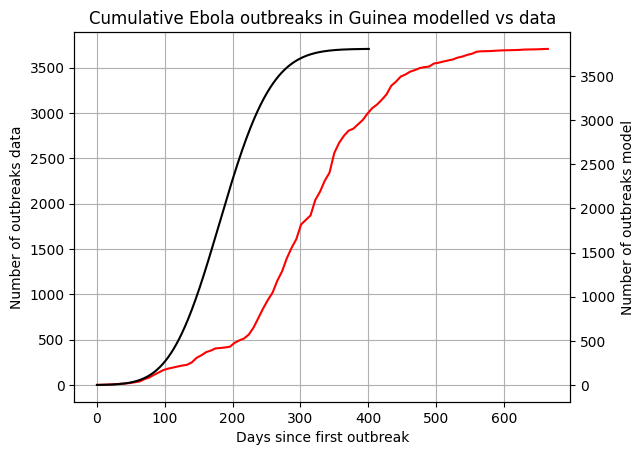

In [46]:
_, ax1 = plt.subplots()
plt.title(f"Cumulative Ebola outbreaks in Guinea modelled vs data")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks data")
ax2 = ax1.twinx()
ax2.set_ylabel("Number of outbreaks model")


ax1.plot(df["Days"], df["Cumulative Cases"], fillstyle="none", color="red")
ax2.plot(t, cumulative_cases, fillstyle="none", color="black")
ax1.grid()

The comparsion between model and data shows that the model fits the cumulative number of outbreaks quite well. However, we see that the model starts growing much earlier than the data. We will explore this by comparing number of new cases:

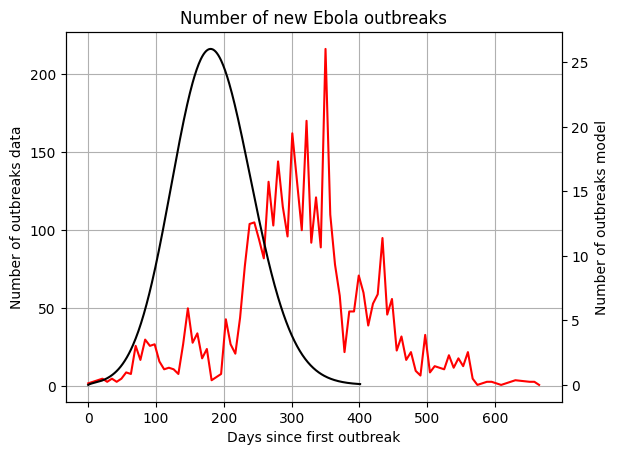

In [47]:
_, ax1 = plt.subplots()
plt.title(f"Number of new Ebola outbreaks")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks data")
ax2 = ax1.twinx()
ax2.set_ylabel("Number of outbreaks model")
ax1.grid()


ax1.plot(df["Days"], df["NumOutbreaks"], fillstyle="none", color="red")
ax2.plot(t, new_outbreaks, fillstyle="none", color="black")

We observed from the comparison between the model and data that the number of new outbreaks are vastly different. This is most likely due to the reporting of new cases in the data happens every week, while the model records new cases each day.

For the model up to this point we have used values for beta0 = 0.351 lam = 0.0049 as they were deemed to be the best fit. We also tried other values for these parameters and compared them to eachother:


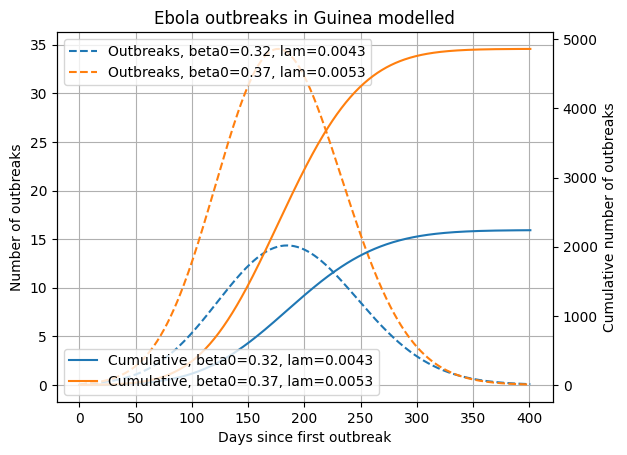

In [48]:
t, c = ode_solver(t0=t0, t_final=t_final, c0=[1e7, 0, 1, 0], dt=dt, f=ebola, beta0=0.32, lam=0.0043)

beta0_lam_set = [(0.32, 0.0043), (0.37, 0.0053)]

_, ax1 = plt.subplots()
plt.title(f"Ebola outbreaks in Guinea modelled")
ax1.set_xlabel("Days since first outbreak")
ax1.set_ylabel("Number of outbreaks")
ax2 = ax1.twinx()
ax2.set_ylabel("Cumulative number of outbreaks")
ax1.grid()

for beta0, lam in beta0_lam_set:
    t, c = ode_solver(t0=t0, t_final=t_final, c0=[1e7, 0, 1, 0], dt=dt, f=ebola, beta0=beta0, lam=lam)
    S, E, Z, R = c.T
    cumulative_cases = Z + R
    new_outbreaks = (1/9.7) * E

    ax1.plot(t, new_outbreaks, label=f"Outbreaks, beta0={beta0}, lam={lam}", fillstyle="none", linestyle="--")
    ax2.plot(t, cumulative_cases, label=f"Cumulative, beta0={beta0}, lam={lam}")

ax1.legend(loc="upper left")
ax2.legend(loc="lower left")





This figure shows how sensitive the model is to small changes to initial transmission rate and decay rate of transmission. Small changes creates big differences in both the cumulative and daily outbreak numbers.

## Conclusion & Discussion

Throughout this project we have explored compartment models to understand the dynamics of outbreaks. We applied this model to a fictional zombie invasion, and also a real Ebola epidemic. Although using a false scenario such as a zombie outbreak, we still get to see the models demonstrating fundemental disease principles that extend to real diseases.  

For the SZ zombie model, the analysis confirmed that with a constant infection rate ($\beta$ > 0), the susceptible population inevitably collapses over time. Extending the model to include time-dependent infection rates $\beta(t)$ showed how human awareness and behavioral changes could reduce infection spread, allowing part of the population to survive. Implementing more compartments in a SEZR model highlighted the roles of incubation periods, removal of zombies, and counter-attacks.  

Even though simple, when applying the compartment model to the Ebola epidemic, it gave us insightful representation of disease progression, and matches reasonably well with the data given for the outbreak. We could make the model fit better by either fine-tuning the parameters even more, or apply an automatic optimization method. To make it more realistic we would need to add more compartments to simulate different interactions between people.  

Throughout all simulations, we found that the models were very senstive to the parameter values. Small changes leads to dramatically different trajectories, which shows the importance of parameter estimation and careful interpretation of model predictions. Numerical experiments further emphasized the need for stable solvers, where choosing apropriate step-size, and if available validation against analytical solutions.

## Self-reflections

**Jahad Ahmed Hamidi**  
In this exercise, I extended the SZ model to the SEZR model by adding exposed humans and removed zombies. I implemented the attack function ω(t) and tested both constant killing and violent counter-attacks. The results showed that without attacks, survival is unlikely if β > α, but with well-timed attacks, humans can survive by reducing the zombie population below 1. This taught me how parameter choices and interventions strongly affect the model outcome.  

**Stian Salte**  
I worked primarily on exercize 5, where I represented data from the real world ebola outbreak into figures for three countries. I also applied the SEZR model to try to simulate the ebola outbreak in Guinea by adjusting the $\beta _0$ and $\lambda$ parameters to try to fit the data figure. By playing around with these values i saw how sensitive such a model can be. 

I thought it was cool to see how simple models were able to simulate a real life outbreak. It would also be neat to see how you could further develop the model to simulate other aspects of an outbreak, something like quarantines.  

**Ruhan Reza**
In this project, I worked on Exercises 1 to 3, where I implemented and tested numerical solvers for the SZ model.

In **Exercise 1**, I visualized the SZ dynamics and observed how the susceptible (S) and zombie (Z) populations changed over time. This gave me a basic understanding of how an outbreak spreads within a population.

In **Exercise 2**, I implemented the Forward Euler method from scratch to solve the SZ-model numerically. I tested the solver against the analytical solution for different time steps and learned how the choice of `Δt` influences the accuracy of the simulation. This deepened my understanding of numerical stability and convergence.

In **Exercise 3**, I extended the model by introducing a time-dependent infection rate `β(t) = β₀e^(-λt)` and simulated two outbreak scenarios: Sokndal and Dirdal. I saw how different `λ` values impacted the outbreak's severity and how small changes in model parameters can lead to very different outcomes. 

Overall, this project helped me improve my Python skills and gave me valuable insight into how simple mathematical models can be used to understand and simulate real-world phenomena like disease outbreaks.

## References

* [1] Hiorth, Aksel. Modeling and Computational Engineering. University of Stavanger, 2024

* [2] National Academies of Sciences, Engineering, and Medicine; Health and Medicine Division; Board on Global Health; Forum on Microbial Threats. The Ebola Epidemic in West Africa: Proceedings of a Workshop. Washington (DC): National Academies Press (US); 2016 Nov 30. 1, Introduction. Available from: https://www.ncbi.nlm.nih.gov/books/NBK401934/

* [3] World Health Organization (2025, April 24). Ebola disease. Available from: https://www.who.int/news-room/fact-sheets/detail/ebola-disease